<a href="https://colab.research.google.com/github/sahiltambe18/DL_CLG/blob/main/lab5_cbow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Lambda, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import io


In [ ]:
# a. Data preparation
def load_data():
    # For this example, we'll use a small corpus
    corpus = [
        "the quick brown fox jumps over the lazy dog",
        "the five boxing wizards jump quickly",
        "how vexingly quick daft zebras jump",
        "the jay pig fox zebra and my wolves quack",
        "sphinx of black quartz judge my vow"
    ]
    return corpus

def prepare_data(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    V = len(tokenizer.word_index) + 1
    sequences = tokenizer.texts_to_sequences(corpus)
    return sequences, V, tokenizer


In [ ]:

# b. Generate training data
def generate_training_data(sequences, window_size, V):
    X = []
    y = []
    for sequence in sequences:
        for i in range(len(sequence)):
            context_start = max(0, i - window_size)
            context_end = min(len(sequence), i + window_size + 1)
            context = sequence[context_start:i] + sequence[i+1:context_end]
            if len(context) > 0:
                X.append(context)
                y.append(sequence[i])
    X = pad_sequences(X, maxlen=window_size*2, padding='pre')
    y = np.array(y)
    return X, y

In [ ]:
# c. Train model
def create_model(V, embedding_dim, max_context_length):
    input_context = Input(shape=(max_context_length,))

    embedding = Embedding(V, embedding_dim, input_length=max_context_length, name='embedding')
    context_embedding = embedding(input_context)

    context_vector = Lambda(lambda x: tf.reduce_mean(x, axis=1))(context_embedding)

    output = Dense(V, activation='softmax')(context_vector)

    model = Model(inputs=input_context, outputs=output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

    return model

def train_model(model, X, y, epochs=50, batch_size=32):
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1
    )
    return history

In [ ]:
# d. Output
def get_embeddings(model, tokenizer):
    weights = model.get_layer('embedding').get_weights()[0]
    reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])
    word_embeddings = {reverse_word_index[i]: weights[i] for i in range(1, len(reverse_word_index) + 1)}
    return word_embeddings

def find_similar_words(word, word_embeddings, n=5):
    target_embedding = word_embeddings[word]
    similarities = {}
    for w, emb in word_embeddings.items():
        if w != word:
            similarity = np.dot(target_embedding, emb) / (np.linalg.norm(target_embedding) * np.linalg.norm(emb))
            similarities[w] = similarity
    return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:n]

In [9]:
# Main execution
if __name__ == "__main__":
    # a. Data preparation
    corpus = load_data()
    sequences, V, tokenizer = prepare_data(corpus)

    # b. Generate training data
    window_size = 2
    X, y = generate_training_data(sequences, window_size, V)

    # c. Train model
    embedding_dim = 100
    max_context_length = window_size * 2
    model = create_model(V, embedding_dim, max_context_length)
    history = train_model(model, X, y)

    # d. Output
    word_embeddings = get_embeddings(model, tokenizer)



Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3.4350 - val_loss: 3.4415
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.4282 - val_loss: 3.4434
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.4214 - val_loss: 3.4454
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.4146 - val_loss: 3.4473
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.4078 - val_loss: 3.4493
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.4010 - val_loss: 3.4512
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.3941 - val_loss: 3.4532
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.3873 - val_loss: 3.4552
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.3804 - val_loss: 3.4572
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.3735 - val_loss: 3.4592
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.3666 - val_loss: 3.4613
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.3596 - val_loss: 3.4634
Epo

In [11]:
# Print some similar words
test_words = ['quick', 'fox', 'jump']
for word in test_words:
        print(f"\nWords similar to '{word}':")
        similar_words = find_similar_words(word, word_embeddings)
        for similar_word, similarity in similar_words:
            print(f"{similar_word}: {similarity:.4f}")



Words similar to 'quick':
daft: 0.2932
jumps: 0.2732
over: 0.2408
dog: 0.2261
vexingly: 0.2227

Words similar to 'fox':
my: 0.3172
the: 0.3144
zebra: 0.1792
wolves: 0.1634
of: 0.1382

Words similar to 'jump':
five: 0.4283
wizards: 0.3346
zebras: 0.2410
my: 0.1637
quickly: 0.1571


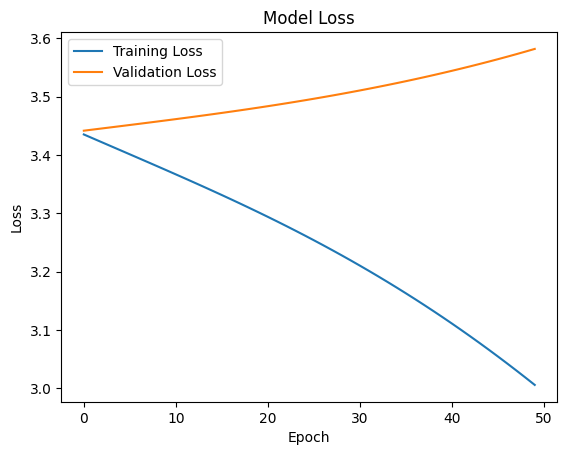

In [13]:
# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()